# Libraries

In [2]:
from albumentations.pytorch import ToTensorV2
import albumentations as A
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import os
import glob
from torch.utils.data import DataLoader
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from time import time
from PIL import Image
import random
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import ConcatDataset

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# from zipfile import ZipFile

# # распаковать архив локально

# with ZipFile('dl-2025-competition-1.zip') as f:
#     f.extractall()

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
!unzip -q /content/drive/MyDrive/dl-2025-competition-1.zip

# Data
 1) Проанализировать данные, посмотреть на баланс классов, посмотреть на представителей классов, сделать выводы.

In [6]:
def load_dataset(train_dir):
    data = []
    class_counts = {}
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        if os.path.isdir(class_path):
          num_images = len(os.listdir(class_path))
          class_counts[int(class_name)] = num_images
          for img_name in os.listdir(class_path):
              img_path = os.path.join(class_path, img_name)
              data.append((img_path, int(class_name)))
    return data, class_counts

def norm_weights(class_counts):
  total_samples = sum(class_counts.values())
  class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
  sum_weights = sum(class_weights.values())
  class_weights_normalized = {cls: weight / sum_weights for cls, weight in class_weights.items()}
  return dict(sorted(class_weights_normalized.items()))

In [7]:
train_path = 'data/train'
dataset, class_counts = load_dataset(train_path)

class_weights_normalized = norm_weights(class_counts)
print(f"Всего изображений: {len(dataset)}")
print(f'веса классов: {class_weights_normalized}')

Всего изображений: 9510
веса классов: {0: 0.007203412731864389, 1: 0.0072694990872025946, 2: 0.005541086716818761, 3: 0.006658616810967082, 4: 0.005826289709596196, 5: 0.017608342233446286, 6: 0.0064420764268705915, 7: 0.005783762047482356, 8: 0.017608342233446286, 9: 0.016170926540920057, 10: 0.005913249257500618, 11: 0.011005213895903927, 12: 0.006772439320556263, 13: 0.0072694990872025946, 14: 0.015847508010101655, 15: 0.005783762047482356, 16: 0.006339003204040662, 17: 0.00565982428932202, 18: 0.016859051074576227, 19: 0.009107763224196354, 20: 0.005741850728297701, 21: 0.006048667179428113, 22: 0.0068902208739572415, 23: 0.024761731265783838, 24: 0.006772439320556263, 25: 0.01131964857864404, 26: 0.01800853182966097, 27: 0.0061904328164459595, 28: 0.005317955708087804, 29: 0.006715045766992226, 30: 0.0061904328164459595, 31: 0.010158658980834394, 32: 0.009004265914830485, 33: 0.017225552184893102, 34: 0.006715045766992226, 35: 0.011005213895903927, 36: 0.006715045766992226, 37: 0.

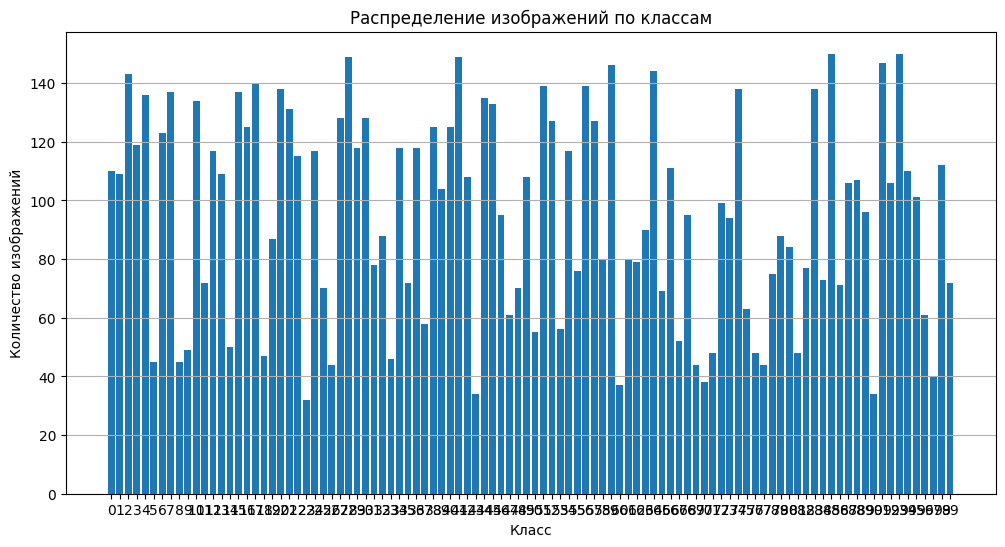

In [8]:
from collections import Counter


labels = [label for _, label in dataset]
class_counts = Counter(labels)

plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Класс")
plt.ylabel("Количество изображений")
plt.title("Распределение изображений по классам")
plt.xticks(sorted(class_counts.keys()))
plt.grid(True, axis='y')
plt.show()

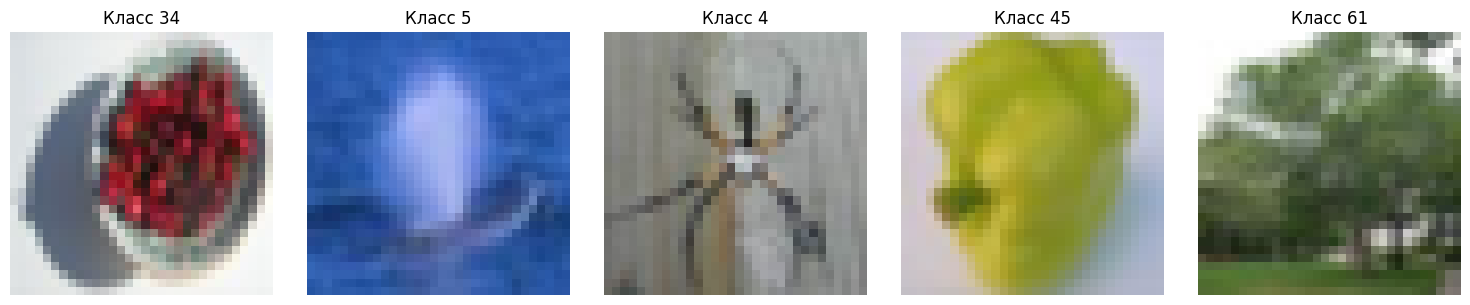

In [9]:
sample = random.sample(dataset, 5)


plt.figure(figsize=(15, 3))
for i, (img_path, label) in enumerate(sample):
    img = Image.open(img_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f'Класс {label}')
    plt.axis('off')
plt.tight_layout()
plt.show()

Анализ распределения классов показывает, что они представлены неравномерно. Некоторые классы имеют существенно больше изображений, чем другие — это может повлиять на обучение модели и привести к перекосу в пользу более представленных классов.

Следует поработать с:
 - Взвешиванием классов при обучении
 - Аугментацией меньшинств

# Albumentation
Проанализировать хороший аугментационный пайплайн с помощью albumentations. Собрать подготовленный пайплайн в погрузчик данных на модель.

In [17]:
!wget https://github.com/Saafke/EDSR_Tensorflow/raw/master/models/EDSR_x4.pb -O EDSR_x4.pb

--2025-04-30 14:38:34--  https://github.com/Saafke/EDSR_Tensorflow/raw/master/models/EDSR_x4.pb
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Saafke/EDSR_Tensorflow/master/models/EDSR_x4.pb [following]
--2025-04-30 14:38:35--  https://raw.githubusercontent.com/Saafke/EDSR_Tensorflow/master/models/EDSR_x4.pb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38573255 (37M) [application/octet-stream]
Saving to: ‘EDSR_x4.pb’

EDSR_x4.pb          100%[===================>]  36.79M  --.-KB/s    in 0.1s    

2025-04-30 14:38:35 (251 MB/s) - ‘EDSR_x4.pb’ saved [38573255/38573255]



In [20]:
# это был очень прикольный апскейлинг, который жестко работал, но он решил рипнуться, поэтому оставляю на память
# без понятия что они сделали с библиотекой, но она просто перестала работать :(

# from cv2 import dnn_superres
# from cv2.dnn_superres import DnnSuperResImpl
# image_path = '/content/data/train/0/6014.png'

# img_pil = Image.open(image_path).convert('RGB')
# img_cv = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

# sr = cv2.dnn_superres.DnnSuperResImpl()

# sr.readModel('EDSR_x4.pb')
# sr.setModel('edsr', 4)

# upscaled = sr.upsample(img_cv)
# upscaled_rgb = cv2.cvtColor(upscaled, cv2.COLOR_BGR2RGB)

# plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
# plt.imshow(img_pil)
# plt.title('Оригинал')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(upscaled_rgb)
# plt.title('Апскейлинг (x4)')
# plt.axis('off')

# plt.tight_layout()
# plt.show()

In [21]:
#простая аугментация
train_transform = A.Compose([
    A.Resize(64, 64, interpolation=cv2.INTER_LANCZOS4),
    A.RandomCrop(64, 64),
    A.RandomRotate90(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [22]:
#продвинутая (элитная) аугментация
train_transform_elite = A.Compose([

    A.Resize(64, 64, interpolation=cv2.INTER_LANCZOS4), # использую окно ланцоша хорошая продвинутая интерполяция чтобы увеличить в х2
    A.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0),
                        ratio=(0.75, 1.33), p=1.0),

    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),

    A.OneOf([
        A.ColorJitter(0.2, 0.2, 0.2, 0.1, p=0.5),
        A.RandomBrightnessContrast(0.2, 0.2, p=0.5),
    ], p=0.8),

    A.OneOf([
        A.MotionBlur(blur_limit=3),
        A.GaussianBlur(blur_limit=3),
        A.MedianBlur(blur_limit=3),
    ], p=0.2),

    A.RandomShadow(p=0.2),

    A.Affine(translate_percent={"x": (-0.0625, 0.0625), "y":(-0.0625, 0.0625)}, scale=(0.9, 1.1), rotate=(-15, 15), p=0.5),

    A.RandomOrder([
         A.OpticalDistortion(p=0.3),
         A.GridDistortion(p=0.3),
         A.ElasticTransform(p=0.3)
    ]),

    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225) ),
    ToTensorV2(),
])

In [ ]:
val_transform = A.Compose([
    A.Resize(64, 64),
    A.CenterCrop(64, 64),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Поделить данные на трейн-валидацию

In [ ]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(dataset, test_size=0.2, stratify=[label for _, label in dataset], random_state=42)

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, data, transforms=None):
        self.data = data
        self.transforms = transforms

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transforms:
            image = self.transforms(image=np.array(image))['image']
        return image, label

    def __len__(self):
        return len(self.data)

In [ ]:
train_dataset_elite = ImageDataset(dataset, transforms=train_transform_elite)
train_loader_elite = DataLoader(train_dataset_elite, batch_size=128, shuffle=True)

train_dataset = ImageDataset(dataset, transforms=train_transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = ImageDataset(val_data, transforms=val_transform)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# TRAINING

In [ ]:
class SimpleModel(nn.Module):

  def __init__(self):
    super(SimpleModel, self).__init__()
    self.cnn = nn.Sequential(
        nn.Conv2d(3, 16, 3, 1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(2),

        nn.Conv2d(16, 32, 3, 1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2),

        nn.Conv2d(32, 64, 3, 1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2),
    )

    self.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(2304, 512, bias=False),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.3),
    nn.Linear(512, 100)
          )

  def forward(self, x):
    return self.classifier(self.cnn(x))

In [ ]:
class PreModel(nn.Module):

    def __init__(self):
        super(PreModel, self).__init__()
        self.premodel = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)

        for param in self.premodel.parameters():
          param.requires_grad = False

        for name, param in self.premodel.named_parameters():
          if "features.5" in name or "features.6" in name or "features.7" in name:
              param.requires_grad = True

        self.premodel.classifier = nn.Identity()

        self.classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(1280, 512, bias=False),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(0.3),
        nn.Linear(512, 100)
              )


    def forward(self, x):
        self.meta = self.premodel(x)
        return self.classifier(self.meta)


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
def lr_lambda(step): # warmup
    if step < warmup_steps:
        return step / warmup_steps
    return 1.0

In [ ]:
def train_loop(model, crit, optim, dl, scheduler=None):
  bl = []
  bac = []
  model.train()

  for _, (x, y) in enumerate(dl):
    ypr = model(x.to("cuda" if torch.cuda.is_available() else "cpu"))
    loss = crit(ypr, y.to("cuda" if torch.cuda.is_available() else "cpu"))
    loss.backward()
    optim.step()
    optim.zero_grad()

    if scheduler:
      scheduler.step()

    bl.append(loss.item())
    bac.append(accuracy_score(y, torch.argmax(ypr.detach().cpu(), dim=-1).numpy()))

  return torch.tensor(bl).mean().item(), torch.tensor(bac).mean().item()

In [ ]:
def test_loop(model, crit, dl):
  bl = []
  bac = []
  model.eval()

  for _, (x, y) in enumerate(dl):
    ypr = model(x.to('cuda'))
    loss = crit(ypr, y.to('cuda'))

    bl.append(loss.item())
    bac.append(accuracy_score(y, torch.argmax(ypr.detach().cpu(), dim=-1).numpy()))

  return torch.tensor(bl).mean().item(), torch.tensor(bac).mean().item()

In [ ]:
def training(model, crit, optim,
             train_loader, val_loader, scheduler,
             lltrain, lltest, lactrain, lactest):

    for epoch in range(epochs):
        train_loss, train_accuracy = train_loop(model, crit, optim, train_loader, scheduler=scheduler)
        val_loss, val_accuracy = test_loop(model, crit, val_loader)

        if epoch%3==0:
            print(f'Эпоха {epoch}')
            print(f'TRAIN CES {train_loss}, ACCURACY {train_accuracy}')
            print(f'TEST CES {val_loss}, ACCURACY {val_accuracy}')
            print()

        lltrain.append(train_loss)
        lltest.append(val_loss)
        lactrain.append(train_accuracy)
        lactest.append(val_accuracy)

        early_stopper(val_loss)

        if early_stopper.early_stop:
            print("МОДЕЛЬ НЕ УЛУЧШАЕТСЯ!!!")
            break

In [ ]:
## без продвинутой Simple и Pre models

In [ ]:
epochs = 25
warmup_steps = 5 * len(train_loader)
total_steps = epochs * len(train_loader)

crit = nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights_normalized.values())).to('cuda'))

modelsim = SimpleModel().to('cuda')
modelpre = PreModel().to('cuda')

optimsim = torch.optim.Adam(modelsim.parameters(), lr=1e-3)
optimpre = torch.optim.Adam(modelpre.parameters(), lr=1e-3)

schedulersim = torch.optim.lr_scheduler.LambdaLR(optimsim, lr_lambda)
schedulerpre = torch.optim.lr_scheduler.LambdaLR(optimpre, lr_lambda)

early_stopper = EarlyStopping(patience=5)

lltrainsim, lltestsim, lactrainsim, lactestsim = [], [], [], []
lltrainpre, lltestpre, lactrainpre, lactestpre = [], [], [], []

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 143MB/s]


Сначала посмотри, как работает базовая аугментация. В моделе реализована ранняя остановка и шедулер:

In [ ]:
from time import time
s = time()
training(modelsim, crit, optimsim, train_loader, val_loader, schedulersim, lltrainsim, lltestsim, lactrainsim, lactestsim)
print(f'{time() - s} секунд')

Эпоха 0
TRAIN CES 4.551133632659912, ACCURACY 0.038229167461395264
TEST CES 3.947345018386841, ACCURACY 0.12020833790302277

Эпоха 3
TRAIN CES 3.379359245300293, ACCURACY 0.2046436369419098
TEST CES 2.8699278831481934, ACCURACY 0.3052367568016052

Эпоха 6
TRAIN CES 2.801346778869629, ACCURACY 0.31103071570396423
TEST CES 2.156651735305786, ACCURACY 0.45625001192092896

Эпоха 9
TRAIN CES 2.347933053970337, ACCURACY 0.39410635828971863
TEST CES 1.5098037719726562, ACCURACY 0.6097821593284607

Эпоха 12
TRAIN CES 1.9779689311981201, ACCURACY 0.4754331409931183
TEST CES 1.1008199453353882, ACCURACY 0.7003882527351379

Эпоха 15
TRAIN CES 1.7174057960510254, ACCURACY 0.5428783297538757
TEST CES 0.7822560667991638, ACCURACY 0.7937878966331482

Эпоха 18
TRAIN CES 1.5873966217041016, ACCURACY 0.5760746002197266
TEST CES 0.780405580997467, ACCURACY 0.8074147701263428

Эпоха 21
TRAIN CES 1.516554594039917, ACCURACY 0.5950383543968201
TEST CES 0.5231695771217346, ACCURACY 0.8737973570823669

Эпоха 

In [ ]:
from time import time
s = time()
training(modelpre, crit, optimpre, train_loader, val_loader, schedulerpre, lltrainpre, lltestpre, lactrainpre, lactestpre)
print(f'{time() - s} секунд')

Эпоха 0
TRAIN CES 4.729222297668457, ACCURACY 0.013788377866148949
TEST CES 4.401488780975342, ACCURACY 0.0589299239218235

Эпоха 3
TRAIN CES 2.4829025268554688, ACCURACY 0.371359646320343
TEST CES 1.8602452278137207, ACCURACY 0.5165625214576721

МОДЕЛЬ НЕ УЛУЧШАЕТСЯ!!!
62.67583727836609 секунд


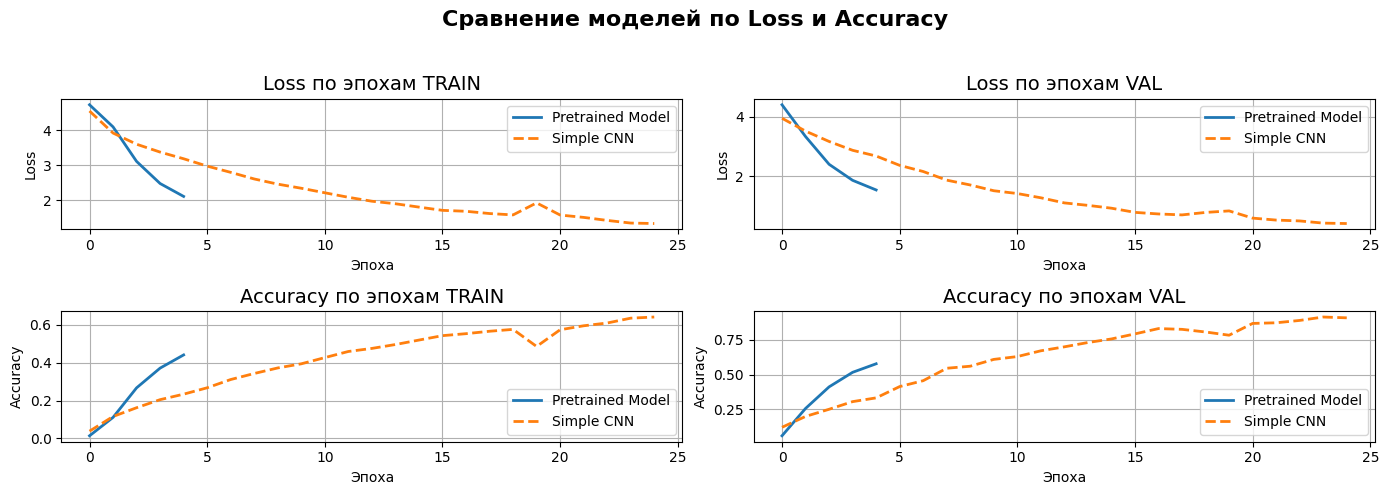

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(14, 5))

ax[0][0].plot(lltrainpre, label='Pretrained Model', linewidth=2)
ax[0][0].plot(lltrainsim, label='Simple CNN', linewidth=2, linestyle='--')
ax[0][0].set_title("Loss по эпохам TRAIN", fontsize=14)
ax[0][0].set_xlabel("Эпоха")
ax[0][0].set_ylabel("Loss")
ax[0][0].grid(True)
ax[0][0].legend()


ax[1][0].plot(lactrainpre, label='Pretrained Model', linewidth=2)
ax[1][0].plot(lactrainsim, label='Simple CNN', linewidth=2, linestyle='--')
ax[1][0].set_title("Accuracy по эпохам TRAIN", fontsize=14)
ax[1][0].set_xlabel("Эпоха")
ax[1][0].set_ylabel("Accuracy")
ax[1][0].grid(True)
ax[1][0].legend()

ax[0][1].plot(lltestpre, label='Pretrained Model', linewidth=2)
ax[0][1].plot(lltestsim, label='Simple CNN', linewidth=2, linestyle='--')
ax[0][1].set_title("Loss по эпохам VAL", fontsize=14)
ax[0][1].set_xlabel("Эпоха")
ax[0][1].set_ylabel("Loss")
ax[0][1].grid(True)
ax[0][1].legend()


ax[1][1].plot(lactestpre, label='Pretrained Model', linewidth=2)
ax[1][1].plot(lactestsim, label='Simple CNN', linewidth=2, linestyle='--')
ax[1][1].set_title("Accuracy по эпохам VAL", fontsize=14)
ax[1][1].set_xlabel("Эпоха")
ax[1][1].set_ylabel("Accuracy")
ax[1][1].grid(True)
ax[1][1].legend()

plt.suptitle("Сравнение моделей по Loss и Accuracy", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
## c продвинутой Simple и Pre models

In [ ]:
epochs = 25
warmup_steps = 5 * len(train_loader_elite)
total_steps = epochs * len(train_loader_elite)

crit = nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights_normalized.values())).to('cuda'))

modelsim = SimpleModel().to('cuda')
modelpre = PreModel().to('cuda')

optimsim = torch.optim.Adam(modelsim.parameters(), lr=1e-3)
optimpre = torch.optim.Adam(modelpre.parameters(), lr=1e-3)

schedulersim = torch.optim.lr_scheduler.LambdaLR(optimsim, lr_lambda)
schedulerpre = torch.optim.lr_scheduler.LambdaLR(optimpre, lr_lambda)

early_stopper = EarlyStopping(patience=5)

lltrainsim, lactestsim, lactrainsim, lactestsim = [], [], [], []
lltrainpre, lactestpre, lactrainpre, lactestpre = [], [], [], []

А тут те же 2 модели, но уже с продвинутой аугментацией:

In [ ]:
from time import time
s = time()
training(modelsim, crit, optimsim, train_loader_elite, val_loader, schedulersim, lltrainsim, lltestsim, lactrainsim, lactestsim)
print(f'{time() - s} секунд')

Эпоха 0
TRAIN CES 4.5268330574035645, ACCURACY 0.0407785102725029
TEST CES 3.921037435531616, ACCURACY 0.1247064396739006

Эпоха 3
TRAIN CES 3.5412211418151855, ACCURACY 0.17818531394004822
TEST CES 2.980846881866455, ACCURACY 0.28120264410972595

Эпоха 6
TRAIN CES 3.0441694259643555, ACCURACY 0.26146382093429565
TEST CES 2.3550448417663574, ACCURACY 0.4045265316963196

Эпоха 9
TRAIN CES 2.70800518989563, ACCURACY 0.31372806429862976
TEST CES 1.9590141773223877, ACCURACY 0.4818466007709503

Эпоха 12
TRAIN CES 2.4671430587768555, ACCURACY 0.36137062311172485
TEST CES 1.6369926929473877, ACCURACY 0.5734090805053711

Эпоха 15
TRAIN CES 2.29085373878479, ACCURACY 0.39512062072753906
TEST CES 1.361192226409912, ACCURACY 0.6241855621337891

Эпоха 18
TRAIN CES 2.130309581756592, ACCURACY 0.42600327730178833
TEST CES 1.0921070575714111, ACCURACY 0.6891950368881226

Эпоха 21
TRAIN CES 2.007791519165039, ACCURACY 0.4571875035762787
TEST CES 0.9735493063926697, ACCURACY 0.7186079621315002

Эпоха 

In [ ]:
from time import time
s = time()
training(modelpre, crit, optimpre, train_loader_elite, val_loader, schedulerpre, lltrainpre, lltestpre, lactrainpre, lactestpre)
print(f'{time() - s} секунд')

Эпоха 0
TRAIN CES 4.7665557861328125, ACCURACY 0.015416666865348816
TEST CES 4.398900985717773, ACCURACY 0.047130681574344635

Эпоха 3
TRAIN CES 2.748016834259033, ACCURACY 0.3174670934677124
TEST CES 1.8195688724517822, ACCURACY 0.49928978085517883

МОДЕЛЬ НЕ УЛУЧШАЕТСЯ!!!
109.06738424301147 секунд


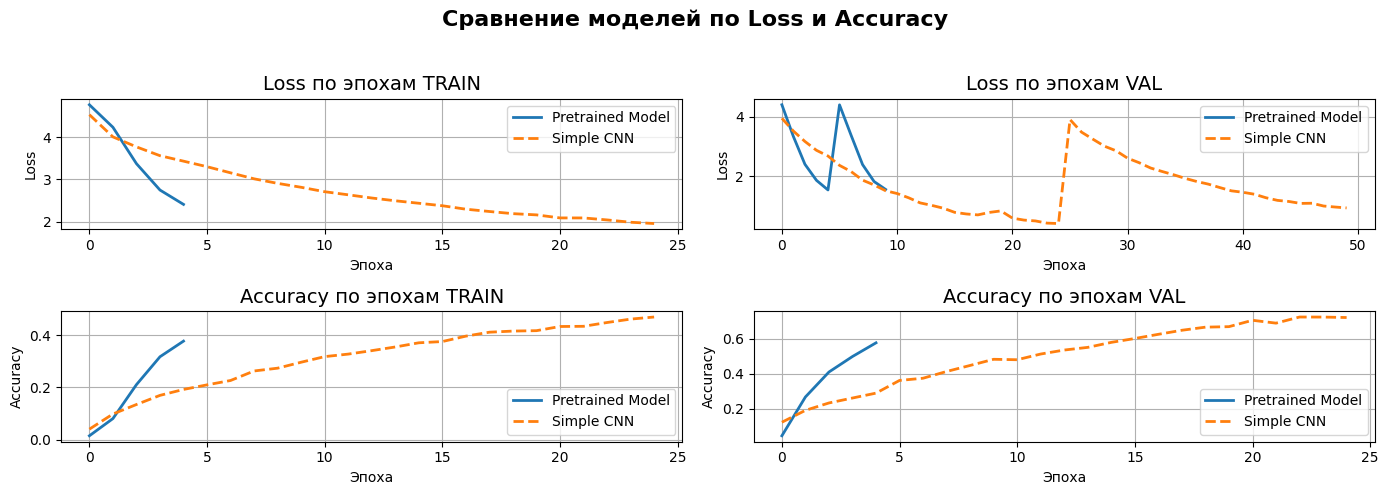

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(14, 5))

ax[0][0].plot(lltrainpre, label='Pretrained Model', linewidth=2)
ax[0][0].plot(lltrainsim, label='Simple CNN', linewidth=2, linestyle='--')
ax[0][0].set_title("Loss по эпохам TRAIN", fontsize=14)
ax[0][0].set_xlabel("Эпоха")
ax[0][0].set_ylabel("Loss")
ax[0][0].grid(True)
ax[0][0].legend()


ax[1][0].plot(lactrainpre, label='Pretrained Model', linewidth=2)
ax[1][0].plot(lactrainsim, label='Simple CNN', linewidth=2, linestyle='--')
ax[1][0].set_title("Accuracy по эпохам TRAIN", fontsize=14)
ax[1][0].set_xlabel("Эпоха")
ax[1][0].set_ylabel("Accuracy")
ax[1][0].grid(True)
ax[1][0].legend()

ax[0][1].plot(lltestpre, label='Pretrained Model', linewidth=2)
ax[0][1].plot(lltestsim, label='Simple CNN', linewidth=2, linestyle='--')
ax[0][1].set_title("Loss по эпохам VAL", fontsize=14)
ax[0][1].set_xlabel("Эпоха")
ax[0][1].set_ylabel("Loss")
ax[0][1].grid(True)
ax[0][1].legend()


ax[1][1].plot(lactestpre, label='Pretrained Model', linewidth=2)
ax[1][1].plot(lactestsim, label='Simple CNN', linewidth=2, linestyle='--')
ax[1][1].set_title("Accuracy по эпохам VAL", fontsize=14)
ax[1][1].set_xlabel("Эпоха")
ax[1][1].set_ylabel("Accuracy")
ax[1][1].grid(True)
ax[1][1].legend()

plt.suptitle("Сравнение моделей по Loss и Accuracy", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Это результаты моделей с продвинутой аугментацией. Буду сверять метрики на pretrained моделе т.к. планирую далее работать с ней. На основе графиков можно сделать вывод, что продвинутые аугментации работают лучше.

# Best Model for competition

In [ ]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.premodel = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)

        for param in self.premodel.parameters():
          param.requires_grad = False

        for name, param in self.premodel.named_parameters():
          if "features.2" in name or "features.3" in name or "features.4" in name or "features.5" in name or "features.6" in name or "features.7" in name:
              param.requires_grad = True

        self.premodel.classifier = nn.Identity()

        self.classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(1280, 512, bias=False),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(0.3),
        nn.Linear(512, 100)
              )


    def forward(self, x):
        self.meta = self.premodel(x)
        return self.classifier(self.meta)


In [ ]:
model = Model().to('cuda')

epochs = 61

crit = nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights_normalized.values())).to('cuda'), label_smoothing=0.1)
optim = torch.optim.Adam(model.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(     # даёт сильный прирост в модели
    optim, max_lr=1e-3,
    steps_per_epoch=len(train_loader_elite),
    epochs=epochs,
)



lltrain = []
lactrain = []
lltest = []
lactest = []

# Train model

In [ ]:
def train_loop(model, crit, optim, dl, scheduler=None):
  bl = []
  bac = []
  model.train()

  for _, (x, y) in enumerate(dl):
    ypr = model(x.to('cuda'))
    loss = crit(ypr, y.to('cuda'))
    loss.backward()
    optim.step()
    optim.zero_grad()

    if scheduler:
      scheduler.step()

    bl.append(loss.item())
    bac.append(accuracy_score(y, torch.argmax(ypr.detach().cpu(), dim=-1).numpy()))

  return torch.tensor(bl).mean().item(), torch.tensor(bac).mean().item()

In [ ]:
def test_loop(model, crit, dl):
  bl = []
  bac = []
  model.eval()

  for _, (x, y) in enumerate(dl):
    ypr = model(x.to('cuda'))
    loss = crit(ypr, y.to('cuda'))

    bl.append(loss.item())
    bac.append(accuracy_score(y, torch.argmax(ypr.detach().cpu(), dim=-1).numpy()))

  return torch.tensor(bl).mean().item(), torch.tensor(bac).mean().item()

In [ ]:
s = time()
for epoch in range(epochs):
        train_loss, train_accuracy = train_loop(model, crit, optim, train_loader_elite, scheduler=scheduler)
        val_loss, val_accuracy = test_loop(model, crit, val_loader)

        if epoch%10==0:
            print(f'Эпоха {epoch}')
            print(f'TRAIN CES {train_loss}, ACCURACY {train_accuracy}')
            print(f'TEST CES {val_loss}, ACCURACY {val_accuracy}')
            print()

        lltrain.append(train_loss)
        lltest.append(val_loss)
        lactrain.append(train_accuracy)
        lactest.append(val_accuracy)
print(f'Время обучения {time() - s} секунд')

Эпоха 0
TRAIN CES 4.88767147064209, ACCURACY 0.01145833358168602
TEST CES 4.707869529724121, ACCURACY 0.024820076301693916

Эпоха 10
TRAIN CES 2.33170485496521, ACCURACY 0.5571984648704529
TEST CES 1.6634066104888916, ACCURACY 0.7523011565208435

Эпоха 20
TRAIN CES 1.6852030754089355, ACCURACY 0.7574835419654846
TEST CES 1.2044943571090698, ACCURACY 0.9447158575057983

Эпоха 30
TRAIN CES 1.3562616109848022, ACCURACY 0.8803837299346924
TEST CES 1.0776456594467163, ACCURACY 0.9873295426368713

Эпоха 40
TRAIN CES 1.1909092664718628, ACCURACY 0.9376096725463867
TEST CES 1.0085217952728271, ACCURACY 0.9973958134651184

Эпоха 50
TRAIN CES 1.1044915914535522, ACCURACY 0.9628015160560608
TEST CES 0.9717265963554382, ACCURACY 1.0

Эпоха 60
TRAIN CES 1.0836018323898315, ACCURACY 0.9690625071525574
TEST CES 0.9675872325897217, ACCURACY 1.0

Время обучения 1377.962641954422 секунд


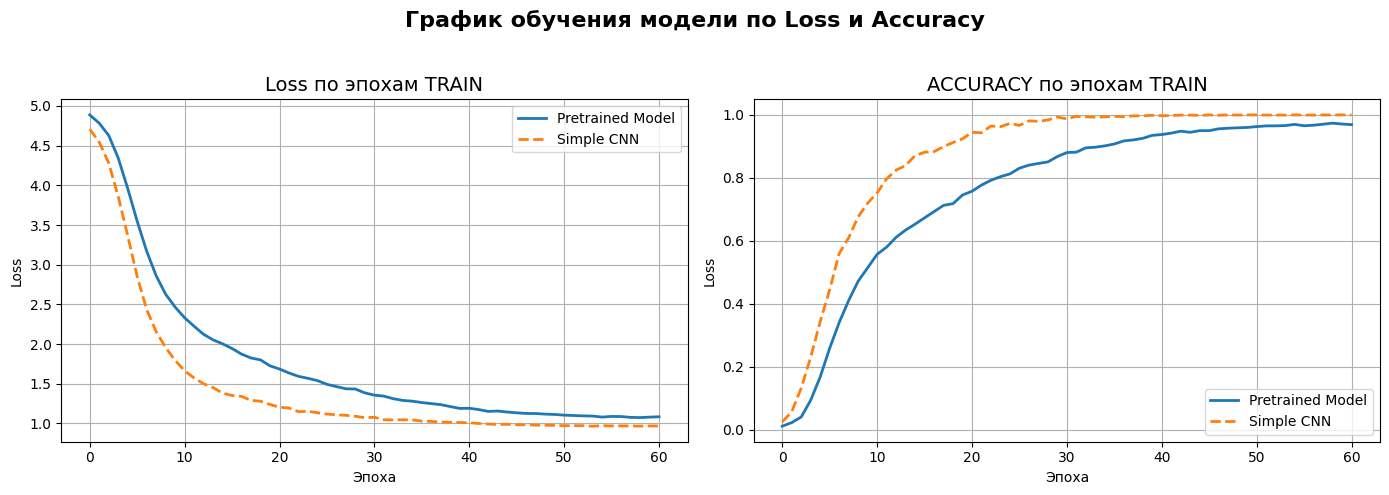

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(lltrain, label='Pretrained Model', linewidth=2)
ax[0].plot(lltest, label='Simple CNN', linewidth=2, linestyle='--')
ax[0].set_title("Loss по эпохам TRAIN", fontsize=14)
ax[0].set_xlabel("Эпоха")
ax[0].set_ylabel("Loss")
ax[0].grid(True)
ax[0].legend()

ax[1].plot(lactrain, label='Pretrained Model', linewidth=2)
ax[1].plot(lactest, label='Simple CNN', linewidth=2, linestyle='--')
ax[1].set_title("ACCURACY по эпохам TRAIN", fontsize=14)
ax[1].set_xlabel("Эпоха")
ax[1].set_ylabel("Loss")
ax[1].grid(True)
ax[1].legend()


plt.suptitle("График обучения модели по Loss и Accuracy", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



# Result

In [ ]:
class TestDataset(Dataset):
    def __init__(self, data, transforms=None):
        self.data = data
        self.transforms = transforms

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(os.path.join('data/test',img_path)).convert('RGB')

        if self.transforms:
            image = self.transforms(image=np.array(image))['image']
        return image

    def __len__(self):
        return len(self.data)

In [ ]:
def load_test(train_dir):
    data = {}
    class_counts = {}
    for class_name in os.listdir(train_dir):
          img_path = os.path.join(class_name)
          data[int(class_name[:-4])] = img_path
    return list(dict(sorted(data.items())).values())

test = TestDataset(load_test('data/test'), transforms=val_transform)

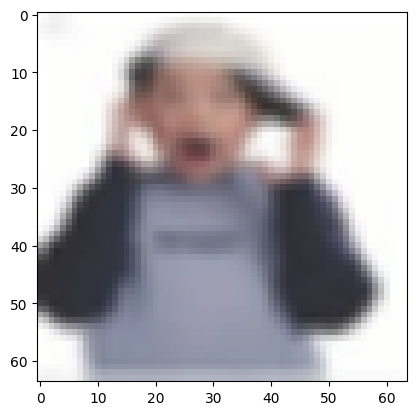

In [ ]:
plt.imshow(test[12].permute(1,2,0)*torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]))

In [ ]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 785315 KiB |   1649 MiB |  10513 GiB |  10512 GiB |
|       from large pool | 712996 KiB |   1552 MiB |  10047 GiB |  10047 GiB |
|       from small pool |  72319 KiB |     98 MiB |    465 GiB |    465 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 785315 KiB |   1649 MiB |  10513 GiB |  10512 GiB |
|       from large pool | 712996 KiB |   1552 MiB |  10047 GiB |

In [ ]:
len(val_dataset)

1902

In [ ]:
for _, (x, y) in enumerate(DataLoader(val_dataset, batch_size=100)):
  model.eval()
  ypr = torch.argmax(model(x.to('cuda')), dim=-1)
  print(accuracy_score(y,ypr.detach().cpu().numpy()))
  break

1.0


In [ ]:
for i, x in enumerate(DataLoader(test, batch_size=100, shuffle=False)):
  model.eval()
  ypr= torch.argmax(model(x.to('cuda')), dim=-1)
  break

In [ ]:
# import pandas as pd
# res = pd.read_csv('sample_submission.csv')
# res['target'] = ypr.detach().cpu().numpy().astype(int)
# res.to_csv('TEST_elite_final_1val.csv', index=False)

from functools import reduce
ypr = []
for i, x in enumerate(DataLoader(test, batch_size=100, shuffle=False)):
  model.eval()
  ypr.append(torch.argmax(model(x.to('cuda')), dim=-1).detach().cpu().tolist())
ypr = np.array(reduce(lambda x, y: x+y, ypr))

import pandas as pd
res = pd.read_csv('sample_submission.csv')
res['target'] = ypr.astype(int)
res.to_csv('TEST_elite_final_stack.csv', index=False)

In [ ]:
res

,id,target
0,0,71
1,1,62
2,2,18
3,3,1
4,4,66
...,...,...
3873,3873,94
3874,3874,42
3875,3875,95
3876,3876,91


# CGAN генерация

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, feature_map_size=64, channels=3, num_classes=100, embed_size=100):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, embed_size)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim + embed_size, feature_map_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_map_size * 8, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_map_size * 4, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_map_size * 2, feature_map_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_map_size, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embedding = self.label_emb(labels)  # (batch_size, embed_size)
        x = torch.cat([noise, label_embedding], dim=1)  # (batch_size, latent_dim + embed_size)
        x = x.unsqueeze(2).unsqueeze(3)  # (batch_size, latent_dim + embed_size, 1, 1)
        return self.model(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, feature_map_size=64, channels=3, num_classes=100, embed_size=100):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, embed_size)

        self.model = nn.Sequential(
            nn.Conv2d(channels + 1, feature_map_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_map_size * 4, feature_map_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_map_size * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_embedding = self.label_emb(labels)
        label_embedding = label_embedding.unsqueeze(2).unsqueeze(3)  # (batch_size, embed_size, 1, 1)
        label_embedding = label_embedding.repeat(1, 1, img.size(2), img.size(3))  # (batch_size, embed_size, H, W)

        x = torch.cat([img, label_embedding[:, 0:1, :, :]], dim=1)  # приклеиваем одну карту метки (можно по-другому)
        return self.model(x).view(-1)

In [ ]:
latent_dim = 100
n_discriminator = 1
n_generator = 1
num_epochs = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator(latent_dim=latent_dim, num_classes=100).to(device)
D = Discriminator(num_classes=100).to(device)

real_label = 1.
fake_label = 0.

optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = torch.nn.BCELoss()

losses_G = []
losses_D = []

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/8] Batch 0/75  Loss_D: 1.4741  Loss_G: 2.3994
Epoch [1/8] Batch 50/75  Loss_D: 0.6142  Loss_G: 4.8409


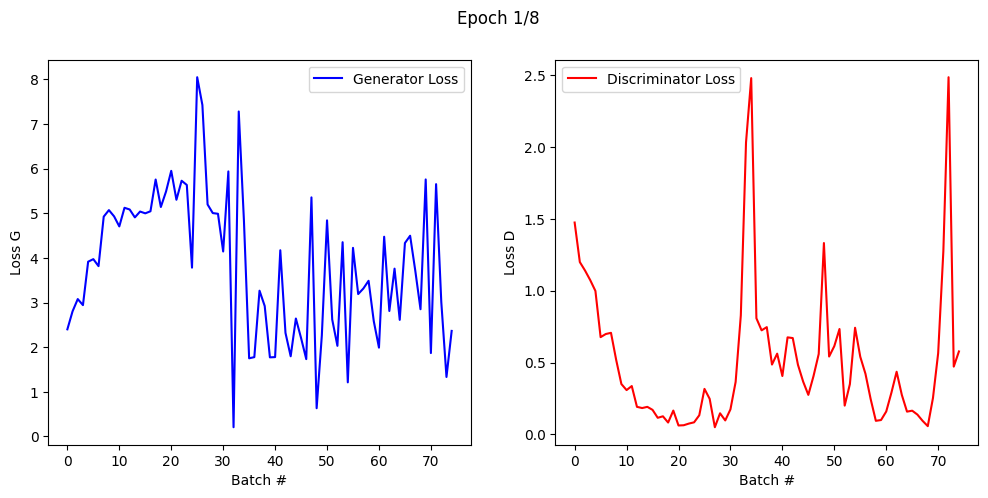

 12%|█▎        | 1/8 [00:35<04:11, 35.91s/it]

Epoch [2/8] Batch 0/75  Loss_D: 0.2657  Loss_G: 3.2520
Epoch [2/8] Batch 50/75  Loss_D: 3.1308  Loss_G: 6.5102


<Figure size 640x480 with 0 Axes>

 25%|██▌       | 2/8 [01:06<03:15, 32.56s/it]

Epoch [3/8] Batch 0/75  Loss_D: 1.0258  Loss_G: 3.1346
Epoch [3/8] Batch 50/75  Loss_D: 1.3712  Loss_G: 1.1257


<Figure size 640x480 with 0 Axes>

 38%|███▊      | 3/8 [01:36<02:37, 31.44s/it]

Epoch [4/8] Batch 0/75  Loss_D: 0.0908  Loss_G: 3.8186
Epoch [4/8] Batch 50/75  Loss_D: 0.0242  Loss_G: 5.1486


<Figure size 640x480 with 0 Axes>

 50%|█████     | 4/8 [02:06<02:03, 30.97s/it]

Epoch [5/8] Batch 0/75  Loss_D: 0.1545  Loss_G: 2.8154
Epoch [5/8] Batch 50/75  Loss_D: 0.0033  Loss_G: 3.4912


<Figure size 640x480 with 0 Axes>

 62%|██████▎   | 5/8 [02:37<01:32, 30.86s/it]

Epoch [6/8] Batch 0/75  Loss_D: 0.0046  Loss_G: 5.8854
Epoch [6/8] Batch 50/75  Loss_D: 0.0082  Loss_G: 3.5868


<Figure size 640x480 with 0 Axes>

 75%|███████▌  | 6/8 [03:07<01:01, 30.66s/it]

Epoch [7/8] Batch 0/75  Loss_D: 0.2092  Loss_G: 2.5153
Epoch [7/8] Batch 50/75  Loss_D: 0.7135  Loss_G: 3.4890


<Figure size 640x480 with 0 Axes>

 88%|████████▊ | 7/8 [03:37<00:30, 30.42s/it]

Epoch [8/8] Batch 0/75  Loss_D: 0.2121  Loss_G: 4.8598
Epoch [8/8] Batch 50/75  Loss_D: 0.0133  Loss_G: 7.6576


<Figure size 640x480 with 0 Axes>

100%|██████████| 8/8 [04:07<00:00, 30.91s/it]


In [ ]:
plt.ion()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

for epoch in tqdm(range(num_epochs)):
    for i, (real_images, real_labels) in enumerate(train_loader_elite):
        real_images, real_labels = real_images.to(device), real_labels.to(device)
        batch_size_curr = real_images.size(0)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        for _ in range(n_discriminator):
            optimizer_D.zero_grad()

            labels_real = torch.full((batch_size_curr,), real_label, device=device)
            output_real = D(real_images, real_labels).view(-1)
            loss_D_real = criterion(output_real, labels_real)
            loss_D_real.backward()

            noise = torch.randn(batch_size_curr, latent_dim, device=device)
            gen_labels = torch.randint(0, 100, (batch_size_curr,), device=device)
            fake_images = G(noise, gen_labels)

            labels_fake = torch.full((batch_size_curr,), fake_label, device=device)
            output_fake = D(fake_images.detach(), gen_labels).view(-1)
            loss_D_fake = criterion(output_fake, labels_fake)
            loss_D_fake.backward()

            loss_D = loss_D_real + loss_D_fake
            optimizer_D.step()

        losses_D.append(loss_D.item())

        # ---------------------
        #  Train Generator
        # ---------------------
        for _ in range(n_generator):
            optimizer_G.zero_grad()

            noise = torch.randn(batch_size_curr, latent_dim, device=device)
            gen_labels = torch.randint(0, 100, (batch_size_curr,), device=device)
            fake_images = G(noise, gen_labels)

            labels_gen = torch.full((batch_size_curr,), real_label, device=device)
            output_fake_for_G = D(fake_images, gen_labels).view(-1)
            loss_G = criterion(output_fake_for_G, labels_gen)
            loss_G.backward()
            optimizer_G.step()

        losses_G.append(loss_G.item())

        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch {i}/{len(train_loader_elite)}  Loss_D: {loss_D.item():.4f}  Loss_G: {loss_G.item():.4f}")

    ax1.clear()
    ax1.plot(losses_G, label="Generator Loss", color='blue')
    ax1.set_xlabel("Batch #")
    ax1.set_ylabel("Loss G")
    ax1.legend()

    ax2.clear()
    ax2.plot(losses_D, label="Discriminator Loss", color='red')
    ax2.set_xlabel("Batch #")
    ax2.set_ylabel("Loss D")
    ax2.legend()

    plt.suptitle(f"Epoch {epoch+1}/{num_epochs}")
    plt.pause(0.1)

plt.ioff()
plt.show()

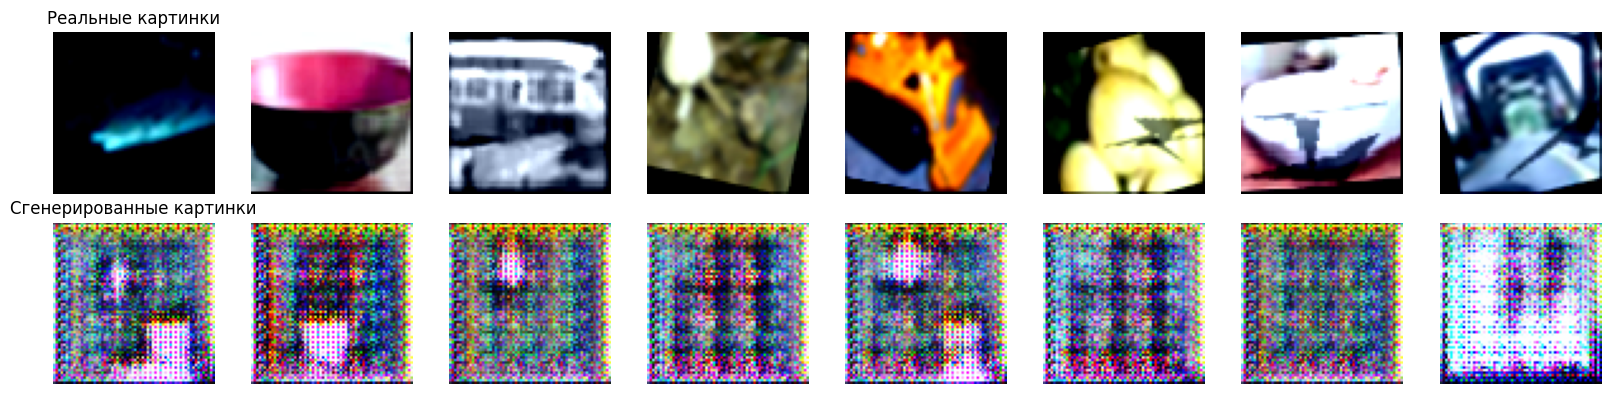

In [ ]:
def denormalize(img_tensor):
    img_tensor = (img_tensor + 1) / 2
    return img_tensor.clamp(0, 1)

real_batch, real_labels = next(iter(train_loader_elite))
real_batch = real_batch.to(device)

noise = torch.randn(real_batch.size(0), latent_dim, device=device)
sampled_labels = torch.randint(0, 100, (real_batch.size(0),), device=device)

with torch.no_grad():
    fake_batch = G(noise, sampled_labels)

n_display = 8
real_imgs = real_batch[:n_display].cpu()
fake_imgs = fake_batch[:n_display].cpu()

fig, axes = plt.subplots(2, n_display, figsize=(n_display * 2, 4))
for i in range(n_display):
    img = denormalize(real_imgs[i]).permute(1, 2, 0).numpy()
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title("Реальные картинки", fontsize=12)

    img_fake = denormalize(fake_imgs[i]).permute(1, 2, 0).numpy()
    axes[1, i].imshow(img_fake)
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title("Сгенерированные картинки", fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
class GenDataset(Dataset):
    def __init__(self, generator, num_samples, latent_dim, num_classes, device):
        self.generator = generator
        self.num_samples = num_samples
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.device = device

        self.generator.eval()
        with torch.no_grad():
            noise = torch.randn(num_samples, latent_dim, device=device)
            labels = torch.randint(0, num_classes, (num_samples,), device=device)
            fake_images = self.generator(noise, labels)

            self.images = fake_images.cpu()
            self.labels = labels.cpu()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.images[idx], torch.tensor(self.labels[idx], dtype=torch.long)

In [ ]:
gen_dataset = GenDataset(G, num_samples=5000, latent_dim=100, num_classes=100, device=device)

In [ ]:
double_dataset = ConcatDataset([train_dataset, gen_dataset])

In [ ]:
def collate_fn(batch):
    """
    Кастомная collate_fn для DataLoader,
    которая собирает изображения в батч и преобразует метки в тензоры.
    """
    images, labels = zip(*batch)  # распаковываем список [(img1, label1), (img2, label2), ...]

    images = torch.stack(images)  # собираем изображения в батч (B, C, H, W)
    labels = torch.tensor(labels, dtype=torch.long)  # преобразуем список int/label в Tensor (B,)

    return images, labels

In [ ]:
double_loader = DataLoader(
    double_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn = collate_fn
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Обучим модель на сдвоенном датасете

In [ ]:
epochs = 7

warmup_steps = 5 * len(train_loader)
total_steps = epochs * len(train_loader)

crit = nn.CrossEntropyLoss() #убрали веса, чтобы не поощрать модели за редкие айтемы, тут так как будто лучше

modelsim = SimpleModel().to("cuda" if torch.cuda.is_available() else "cpu")

optimsim = torch.optim.Adam(modelsim.parameters(), lr=1e-3)

schedulersim = torch.optim.lr_scheduler.LambdaLR(optimsim, lr_lambda)

early_stopper = EarlyStopping(patience=5)

lltrainsim, lltestsim, lactrainsim, lactestsim = [], [], [], []

In [ ]:
#тут выдает какие-то варнинги (видимо из-за того, как формируются тензоры, но по идее от этого решение не становится неверным)
from warnings import filterwarnings
filterwarnings('ignore')

s = time()
training(modelsim, crit, optimsim, double_loader, val_loader, schedulersim, lltrainsim, lltestsim, lactrainsim, lactestsim)
print(f'{time() - s} секунд')

Эпоха 0
TRAIN CES 3.3702657222747803, ACCURACY 0.2988262474536896
TEST CES 3.693906545639038, ACCURACY 0.15439394116401672

Эпоха 3
TRAIN CES 2.151702642440796, ACCURACY 0.4879273474216461
TEST CES 2.698455333709717, ACCURACY 0.33223482966423035

Эпоха 6
TRAIN CES 1.8620561361312866, ACCURACY 0.5431699752807617
TEST CES 2.0141398906707764, ACCURACY 0.49157196283340454

67.00684189796448 секунд


In [ ]:
#логично, что метрика хуже, чем на обычном датасете т.к. качество сгенерированных картинок оставляет желать лучшего